In [21]:
import pandas as pd
import networkx as nx
from itertools import combinations
from scipy.stats import pearsonr
import numpy as np
import pickle as pkl
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/shared/norm_count.csv", index_col = 0)
# Multiindex columns to be (cellline, gene, shRNA, replicate)
df.columns=pd.MultiIndex.from_tuples([tuple(x.split()[-4:]) for x in df.columns])
genes = sorted(set(x[1] for x in df.columns))
genes.remove("CTRL")
systems = sorted(set(x[1] for x in df.columns))
networks = {x: None for x in systems}
corr = {x: None for x in systems}
for g in systems:
    data = df.xs(g, axis=1, level=1, drop_level=False).loc[genes]
    pearson = pd.DataFrame(0, columns=genes, index=genes)
    for i, j in combinations(genes, 2):
        pearson.loc[i,j] = pearsonr(data.loc[i], data.loc[j])[0]
    pearson += pearson.T
    np.fill_diagonal(pearson.values, 1.0)
    corr[g] = pearson
pkl.dump(corr, open("/shared/tony/corr_coeff_20.pkl", "wb"))
change = []
for i, j in combinations(systems, 2):
    data = abs(corr[i] - corr[j])
    change += [((i, j), (genes[x[0]], genes[x[1]], data.loc[genes[x[0]], genes[x[1]]], corr[i].loc[genes[x[0]], genes[x[1]]], corr[j].loc[genes[x[0]], genes[x[1]]])) for x in np.argwhere(np.triu(data.values) > 0.5)]
len(change)
s = sorted(change, key=lambda x: x[1][2], reverse=True)
pkl.dump(s, open("/shared/tony/change_20.pkl", "wb"))
with open("/shared/tony/change_20.csv", "w") as f:
    f.write("sys1,sys2,gene1,gene2,corr_change,sys1_corr,sys2_corr\n")
    for i in s:
        f.write(",".join([str(y) for x in i for y in x]) + "\n")

In [332]:
large_genes = []
for g in genes:
    data = pd.read_csv(f"/shared/DE_DESeq/CTRL_vs_{g}_results_DESeq.csv", index_col=0)
    large_genes += list(data[data.padj < 0.05].sort_values("padj").index[:100])

In [336]:
large_genes = sorted(set(large_genes))

In [323]:
def calc_pearson(data, gene_list):
    pearson = pd.DataFrame(0, columns=gene_list, index=gene_list)
    for i, j in tqdm(list(combinations(gene_list, 2))):
        pearson.loc[i,j] = pearsonr(data.loc[i], data.loc[j])[0]
    pearson += pearson.T
    np.fill_diagonal(pearson.values, 1.0)
    return pearson

In [313]:
df = pd.read_csv("/shared/norm_count.csv", index_col = 0)
# Multiindex columns to be (cellline, gene, shRNA, replicate)
df.columns=pd.MultiIndex.from_tuples([tuple(x.split()[-4:]) for x in df.columns])
systems = sorted(set(x[1] for x in df.columns))
networks = {x: None for x in systems}
corr = {x: None for x in systems}
for g in systems:
    data = df.xs(g, axis=1, level=1, drop_level=False).loc[large_genes]
    pearson = pd.DataFrame(0, columns=large_genes, index=large_genes)
    for i, j in combinations(large_genes, 2):
        pearson.loc[i,j] = pearsonr(data.loc[i], data.loc[j])[0]
    pearson += pearson.T
    np.fill_diagonal(pearson.values, 1.0)
    corr[g] = pearson
pkl.dump(corr, open("/shared/tony/corr_coeff_large.pkl", "wb"))
change = []
for i, j in combinations(systems, 2):
    data = abs(corr[i] - corr[j])
    change += [((i, j), (large_genes[x[0]], large_genes[x[1]], data.loc[large_genes[x[0]], large_genes[x[1]]], corr[i].loc[large_genes[x[0]], large_genes[x[1]]], corr[j].loc[large_genes[x[0]], large_genes[x[1]]])) for x in np.argwhere(np.triu(data.values) > 0.5)]
s = sorted(change, key=lambda x: x[1][2], reverse=True)
pkl.dump(s, open("/shared/tony/change_large.pkl", "wb"))
with open("/shared/tony/change_large.csv", "w") as f:
    f.write("sys1,sys2,gene1,gene2,corr_change,sys1_corr,sys2_corr\n")
    for i in s:
        f.write(",".join([str(y) for x in i for y in x]) + "\n")

KeyboardInterrupt: 

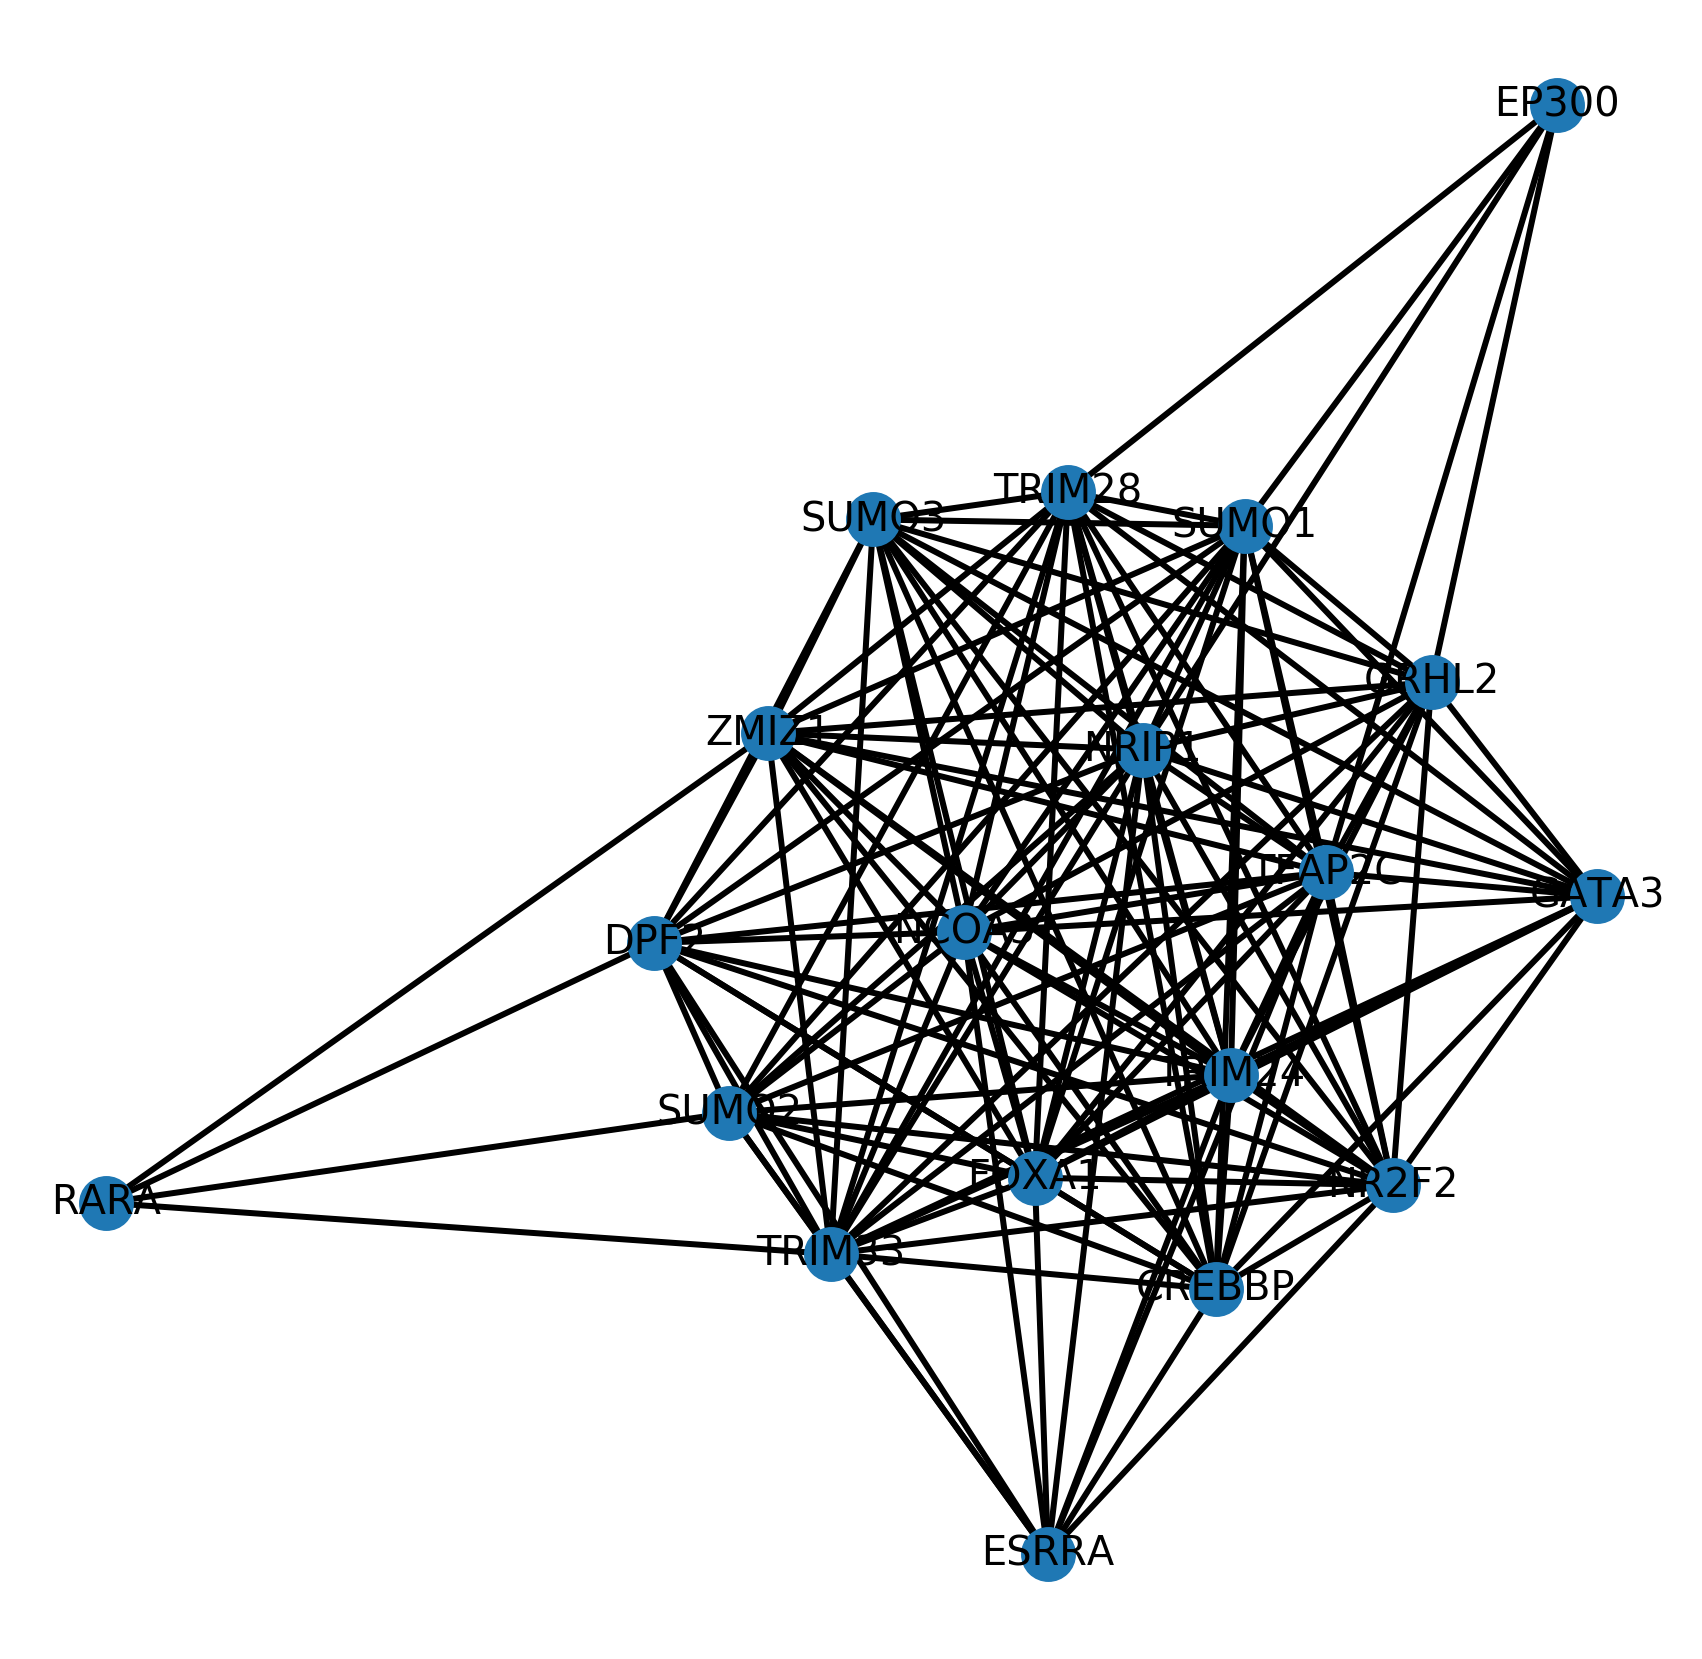

In [50]:
def mat_to_net(df):
    G = nx.Graph()
    posi = []
    neg = []
    for x in np.argwhere(abs(np.triu(df.values)) > 0.5):
        G.add_edge(genes[x[0]], genes[x[1]], weight=1/abs(df.loc[genes[x[0]], genes[x[1]]]))
        if df.loc[genes[x[0]], genes[x[1]]] > 0.5:
            posi.append((genes[x[0]], genes[x[1]]))
        elif df.loc[genes[x[0]], genes[x[1]]] < -0.5:
            neg.append((genes[x[0]], genes[x[1]]))
    pos = nx.spring_layout(G)  # positions for all nodes

    plt.figure(figsize=(15, 15))
    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)
    colors = range(21)
    # edges
    nx.draw_networkx_edges(G, pos, width=3)
#     nx.draw_networkx_edges(
#         G, pos, edgelist=neg, width=3, alpha=0.5, edge_color="b", style="dashed"
#     )

    # labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

    plt.axis("off")
    return plt.show()
mat_to_net(corr["CTRL"])

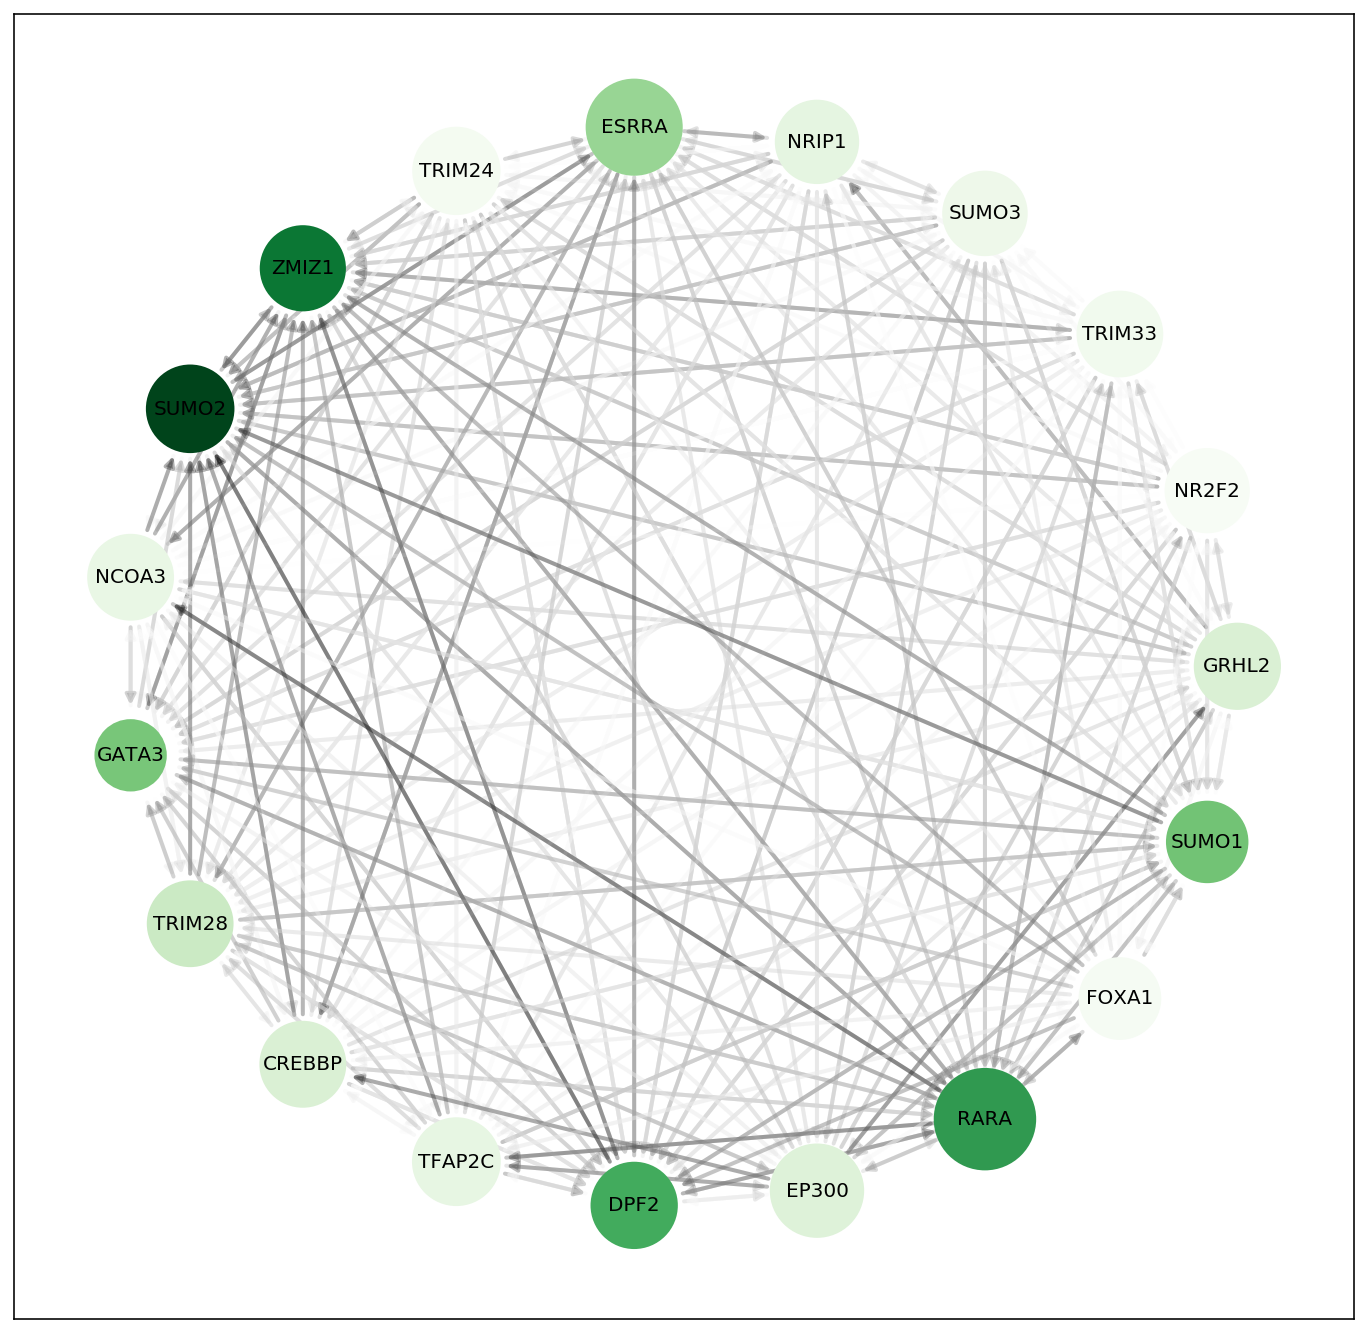

In [145]:
genes = ['GRHL2', 'NR2F2', 'TRIM33', 'SUMO3', 'NRIP1', 'ESRRA', 'TRIM24',
       'ZMIZ1', 'SUMO2', 'NCOA3', 'GATA3', 'TRIM28', 'CREBBP', 'TFAP2C',
       'DPF2', 'EP300', 'RARA', 'FOXA1', 'SUMO1']
d = pd.concat([(corr[g] - corr['CTRL'])[g] for g in genes], axis=1)
d = abs(d).reindex(index=genes)
cut = 0
d[d<cut] = 0
G = nx.DiGraph()
G.add_nodes_from(np.arange(0, len(d.columns), 1))
labels = {}
node_colors = []
colors = []
sizes = []
for idx, node in enumerate(G.nodes()):
    labels[node] = d.columns.values[idx]
for i in range(0, len(d.columns)):
    sizes.append(300 * np.sum(d.iloc[i, :]))
    node_colors.append(np.sum(d.iloc[:, i]))
    for j in range(0, len(d.columns)):
        if i != j and d.iloc[i, j] != 0:
            G.add_edge(i, j)
            colors.append(d.iloc[i, j])
colors = (np.array(colors) - cut) / (max(colors) - cut)
plt.figure(figsize=(12, 12))
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.Greens, node_size=sizes, alpha=1.0)
nx.draw_networkx_edges(G, pos, edge_color=colors, edge_cmap=plt.cm.binary, edge_vmin=0.0, width=2.0, arrowstyle='-|>', alpha=0.4, min_source_margin=25, min_target_margin=25)
nx.draw_networkx_labels(G, pos, labels, font_size=10)
plt.show()

In [216]:
genes = ['GRHL2', 'NR2F2', 'TRIM33', 'SUMO3', 'NRIP1', 'ESRRA', 'TRIM24',
       'ZMIZ1', 'SUMO2', 'NCOA3', 'GATA3', 'TRIM28', 'CREBBP', 'TFAP2C',
       'DPF2', 'EP300', 'RARA', 'FOXA1', 'SUMO1']

In [217]:
cut = 0.5

In [248]:
# d = pd.concat([(corr[g] - corr['CTRL'])[((abs(corr[g]) > cut) & (abs(corr['CTRL']) > cut))].loc[g:g] for g in genes], axis=0).reindex(genes, axis=1)

rows = []
for g in genes:
    selection = (abs(corr[g]) > cut) & (abs(corr['CTRL']) > cut)
    rows.append((corr[g] - corr['CTRL'])[selection].loc[g:g])
d = pd.concat(rows).reindex(genes, axis=1)

In [249]:
d

,GRHL2,NR2F2,TRIM33,SUMO3,NRIP1,ESRRA,TRIM24,ZMIZ1,SUMO2,NCOA3,GATA3,TRIM28,CREBBP,TFAP2C,DPF2,EP300,RARA,FOXA1,SUMO1
GRHL2,0.000000,0.262124,0.227705,0.033228,-0.178604,NaN,0.170175,-0.315437,NaN,0.228938,0.134629,0.080909,0.334243,0.129871,NaN,NaN,NaN,-0.010522,-0.034260
NR2F2,NaN,0.000000,0.002567,0.032577,0.125522,NaN,0.007830,0.100306,-0.184838,0.002310,0.082395,0.044525,-0.058007,0.063663,-0.058495,NaN,NaN,0.001128,0.066655
TRIM33,NaN,-0.031082,0.000000,0.010816,0.073344,NaN,-0.024331,NaN,-0.202472,-0.019132,0.036074,0.029156,-0.022007,0.009092,-0.091290,NaN,NaN,-0.043150,0.051703
SUMO3,0.015020,-0.060364,-0.064181,0.000000,-0.303691,NaN,-0.081047,0.069162,NaN,-0.051344,-0.139419,-0.076801,-0.040775,-0.209363,-0.247843,NaN,NaN,-0.209597,-0.137548
NRIP1,NaN,0.055798,0.054290,-0.123378,0.000000,NaN,0.013755,0.134317,-0.207560,0.048260,0.182864,-0.034959,0.098423,-0.041503,-0.150024,NaN,NaN,-0.002480,-0.117642
ESRRA,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRIM24,NaN,-0.075834,-0.088490,-0.054935,-0.019212,-0.103748,0.000000,0.108259,-0.189076,-0.081665,-0.174784,-0.053423,-0.232797,-0.082513,0.002657,NaN,NaN,-0.152373,-0.018627
ZMIZ1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SUMO2,NaN,NaN,NaN,NaN,1.135612,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,-1.393065,NaN,NaN,NaN,1.103582
NCOA3,0.301439,-0.014822,-0.008966,-0.037525,0.013201,NaN,-0.005510,0.189729,-0.079281,0.000000,0.082677,-0.015749,-0.012045,0.007932,0.135666,NaN,NaN,-0.048138,-0.013060


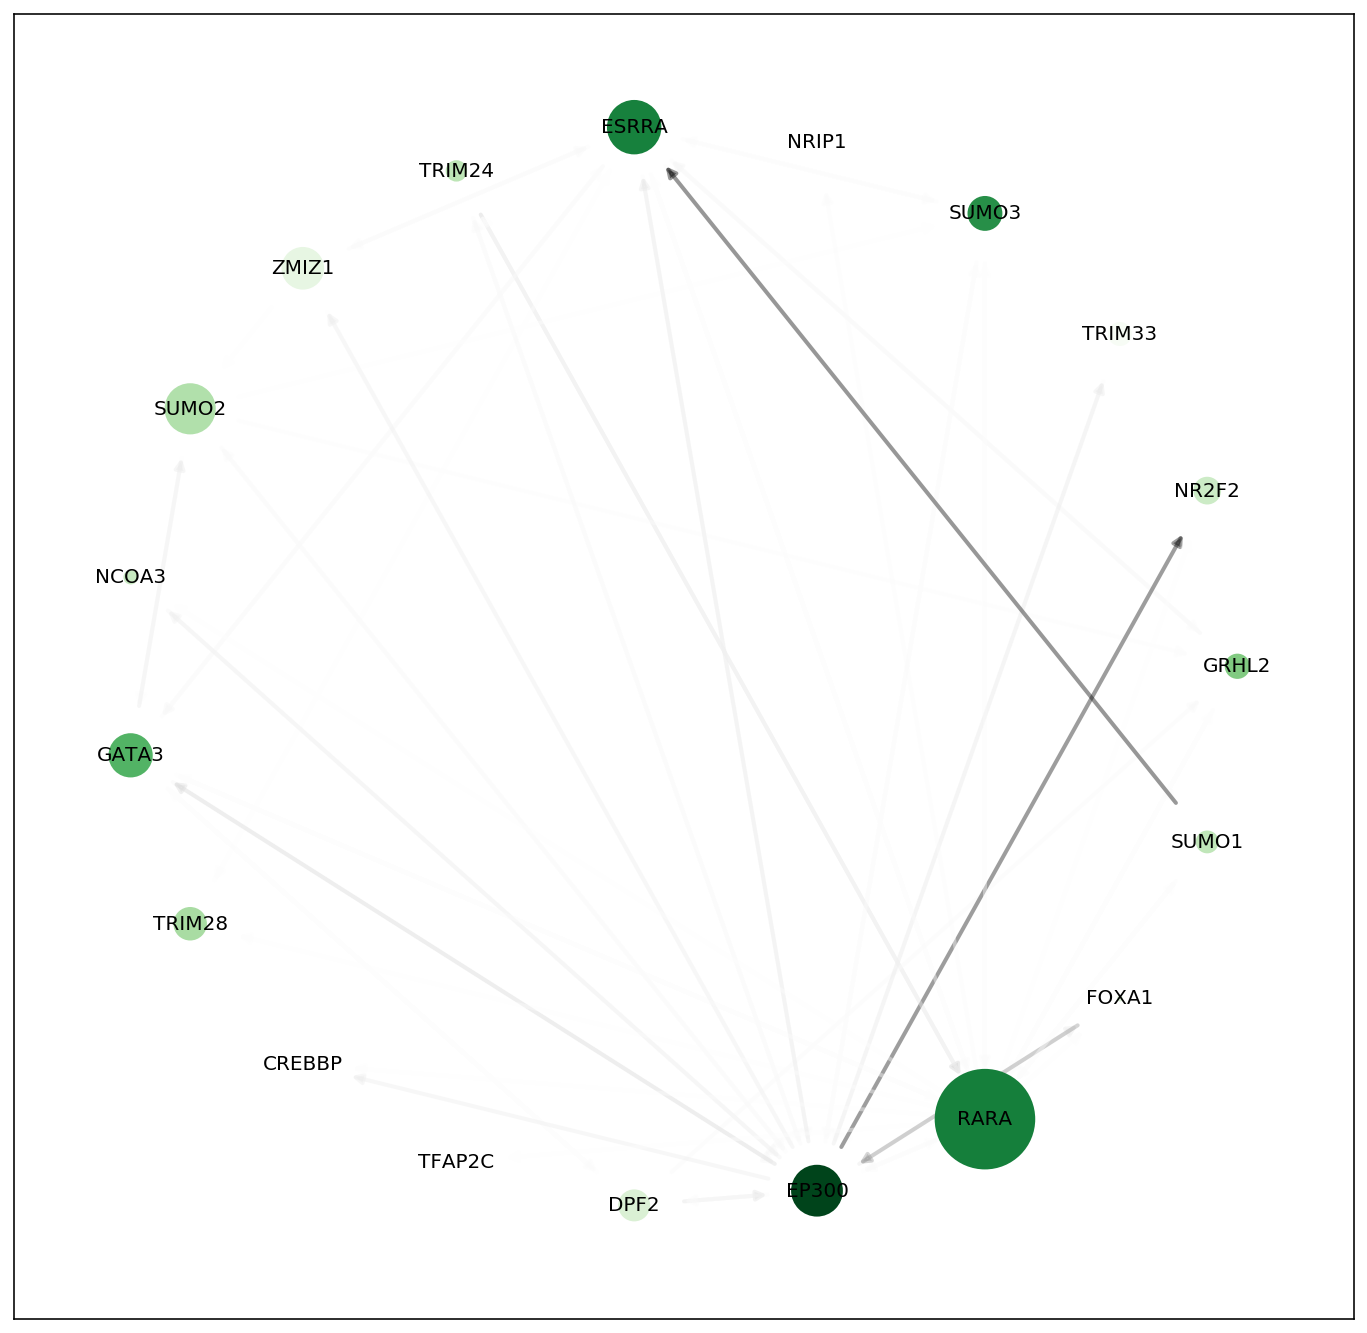

In [245]:
absd = abs(d)
G = nx.DiGraph()
G.add_nodes_from(np.arange(0, len(absd.columns), 1))
labels = {}
node_colors = []
colors = []
sizes = []
for idx, node in enumerate(G.nodes()):
    labels[node] = absd.columns.values[idx]
for i in range(0, len(absd.columns)):
    sizes.append(300 * np.sum(absd.iloc[i, :]))
    node_colors.append(np.sum(absd.iloc[:, i]))
    for j in range(0, len(absd.columns)):
        if i != j and not np.isnan(absd.iloc[i, j]):
            G.add_edge(i, j)
            colors.append(1/absd.iloc[i, j])
plt.figure(figsize=(12, 12))
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.Greens, node_size=sizes, alpha=1.0)
nx.draw_networkx_edges(G, pos, edge_color=colors, edge_cmap=plt.cm.binary, edge_vmin=0.0, width=2.0, arrowstyle='-|>', alpha=0.4, min_source_margin=25, min_target_margin=25)
nx.draw_networkx_labels(G, pos, labels, font_size=10)
plt.show()

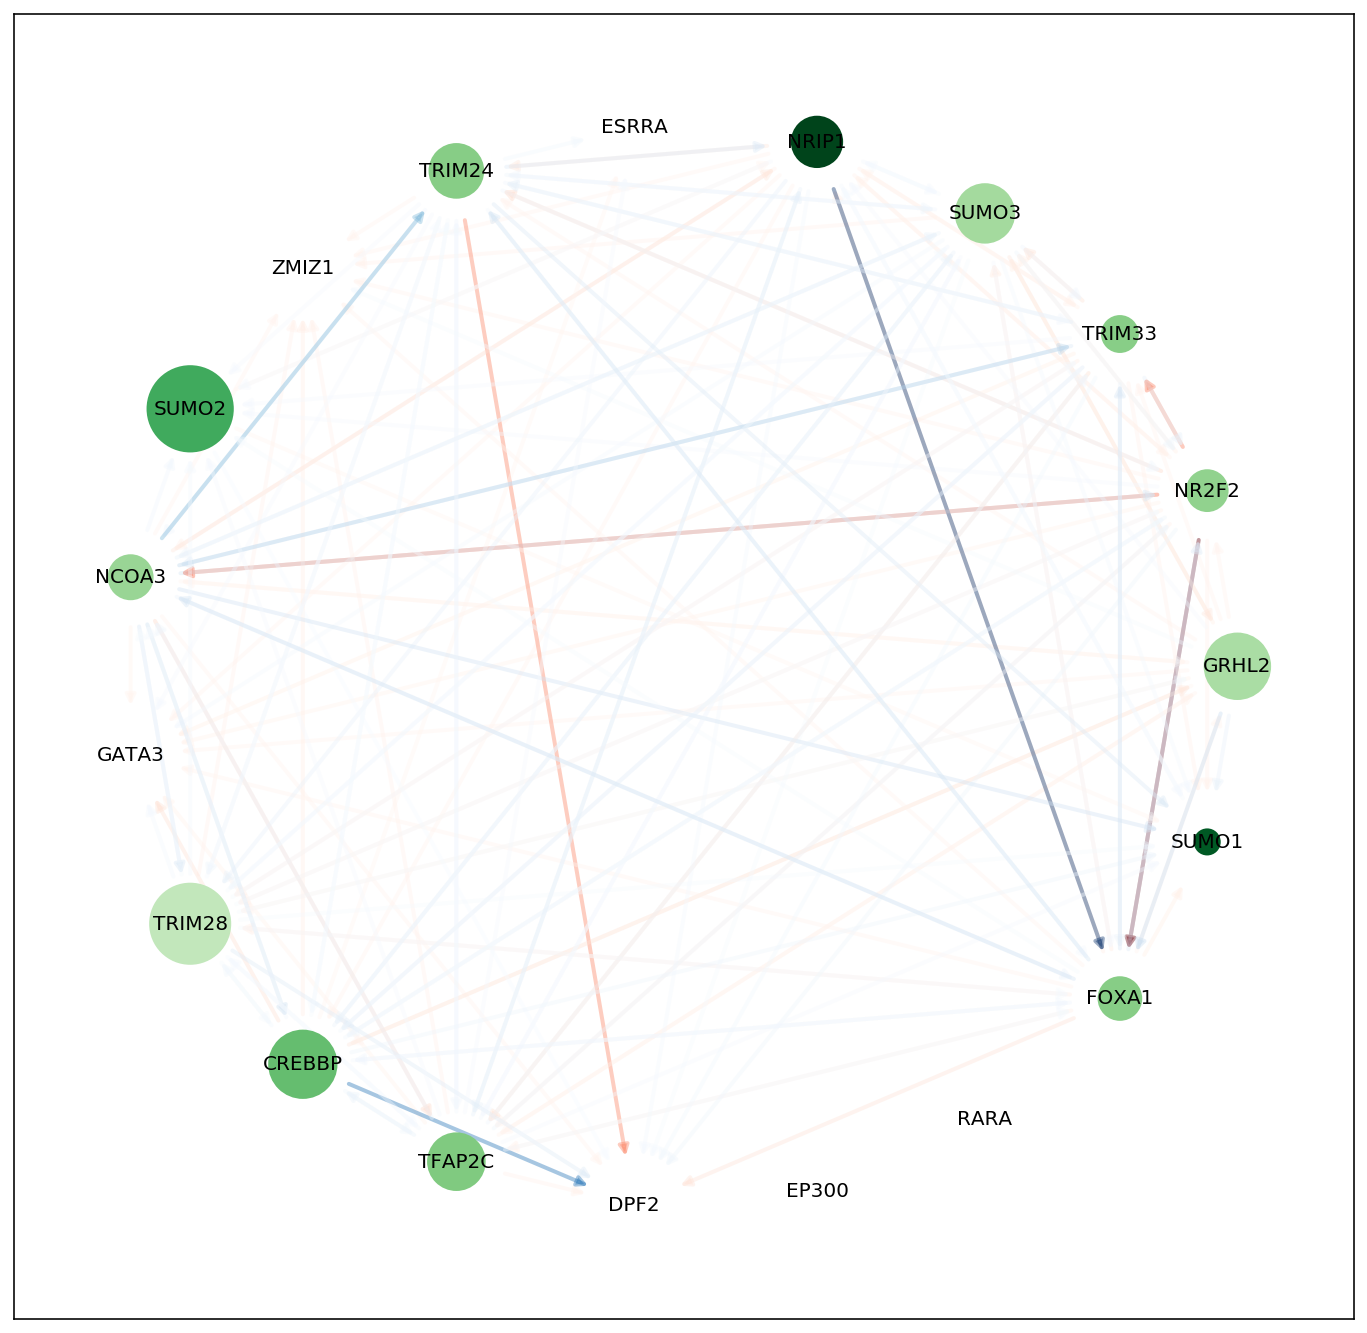

In [250]:
G = nx.DiGraph()
G.add_nodes_from(np.arange(0, len(d.columns), 1))
labels = {}
node_colors = []
pcolors = []
ncolors = []
sizes = []
positive = []
negative = []
for idx, node in enumerate(G.nodes()):
    labels[node] = d.columns.values[idx]
for i in range(0, len(d.columns)):
    sizes.append(500 * np.sum(abs(d.iloc[i, :])))
    node_colors.append(np.sum(abs(d.iloc[:, i])))
    for j in range(0, len(d.columns)):
        if i != j:
            if d.iloc[i, j] > 0:
                G.add_edge(i, j)
                pcolors.append(1/d.iloc[i, j])
                positive.append((i, j))
            elif d.iloc[i, j] < 0:
                G.add_edge(i, j)
                ncolors.append(1/abs(d.iloc[i, j]))
                negative.append((i, j))
plt.figure(figsize=(12, 12))
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.Greens, node_size=sizes, alpha=1.0)
nx.draw_networkx_edges(G, pos, edge_color=pcolors, edgelist= positive, edge_cmap=plt.cm.Reds, edge_vmin=0.0, width=2.0, arrowstyle='-|>', alpha=0.4, min_source_margin=25, min_target_margin=25)
nx.draw_networkx_edges(G, pos, edge_color=ncolors, edgelist= negative, edge_cmap=plt.cm.Blues, edge_vmin=0.0, width=2.0, arrowstyle='-|>', alpha=0.4, min_source_margin=25, min_target_margin=25)
# nx.draw_networkx_edges(G, pos, edge_color="y", edgelist= largest, edge_vmin=0.0, width=2.0, arrowstyle='-|>', alpha=0.4, min_source_margin=25, min_target_margin=25)
nx.draw_networkx_labels(G, pos, labels, font_size=10)
plt.show()